# Exercises

<font size='4'>
Lets start by improving on the bigram frequency model by implementing a generic n-gram model.
</font>

In [1]:
with open('names.txt') as f:
	words = f.read().splitlines()

In [2]:
import torch

In [5]:
class ngram:
	"""
	n-gram model using counting to train and generate new words.
	"""

	def __init__(self, n: int = 1):
		"""
		Initialize the instance by setting _train to False.
		"""
		self._train = False
		self.n = n

	def train(self, data, smoothing: int = 0):
		"""
		Method to train the model given a list of words, the size of the context to be used, and smoothing.
		Arguments:
			data: list of words to be used for training
			n: integer that is size of context to be used to predict next character
			smoothing: integer that is false count added to all elements
		Returns:
			None
		"""
		self.smoothing = smoothing
		self.ctoi = {c: i+1 for i, c in enumerate(sorted(list(set(''.join(data)))))}
		self.ctoi['.'] = 0
		self.itoc = {i: c for c, i in self.ctoi.items()}
		self.context_indices = lambda x: self.ctoi[x]
		self.N = torch.zeros([len(self.ctoi)] * (self.n+1), dtype=torch.int32)
		self.N += smoothing

		for word in data:
			context = ['.']*self.n
			for char in word + '.':
				indices = tuple(map(self.context_indices, context))
				self.N[indices][self.ctoi[char]] += 1
				context = context[1:] + [char]

		self.P = self.N / self.N.sum(dim=self.n, keepdim=True)
		self._train = True

	def eval(self, data) -> float:
		"""
		Method to evaluate performance of the trained model using the negative log-likelihood function.
		Arguments:
			data: list of strings to evaluate the performance of the model on.
		Returns:
			average negative log-likelihood calculated over whole dataset
		"""
		if self._train is None:
			print("Model must be trained first")
			return

		nll = 0
		n = 0
		for word in data:
			context = ['.']*self.n
			for char in word + '.':
				indices = tuple(map(self.context_indices, context))
				idx = self.ctoi[char]
				p = self.P[indices] # probabilities of all characters to follow context (conditioning on context)
				nll += -torch.log(p[idx])
				n += 1
				context = context[1:] + [char]

		print(f"Loss of {self.n+1}-gram model with smoothing of {self.smoothing}: {nll.item()/n}")
		return nll.item()/n

	def generate(self, n, generator=None):
		""" Generate n new things from the trained model. Can make it deterministic, by setting generator to True
		Otherwise can leave generator as None or provide own generator. """

		if self._train is None:
			print("Model must be trained first")
			return

		if isinstance(generator, bool) and generator:
			generator = torch.Generator().manual_seed(2147483647)
		elif not isinstance(generator, torch.Generator):
			generator = None
		
		for _ in range(n):
			context = ['.']*self.n
			word = ''
			while True:
				indices = tuple(map(self.context_indices, context))
				probs = self.P[indices]
				choice = torch.multinomial(probs, 1, replacement=True, generator=generator).item()
				if choice == 0:
					break
				word += self.itoc[choice]
				context = context[1:] + [self.itoc[choice]]
			print(word)

We can now compare a bunch of n-gram models and their performance.

In [6]:
losses = []

for i in range(1, 6):
	model = ngram(i)
	model.train(words)
	losses.append(model.eval(words))

Loss of 2-gram model with smoothing of 0: 2.454094088872915
Loss of 3-gram model with smoothing of 0: 2.1856520879173864
Loss of 4-gram model with smoothing of 0: 1.8840234159266436
Loss of 5-gram model with smoothing of 0: 1.6055300114838744
Loss of 6-gram model with smoothing of 0: 1.477782867111411


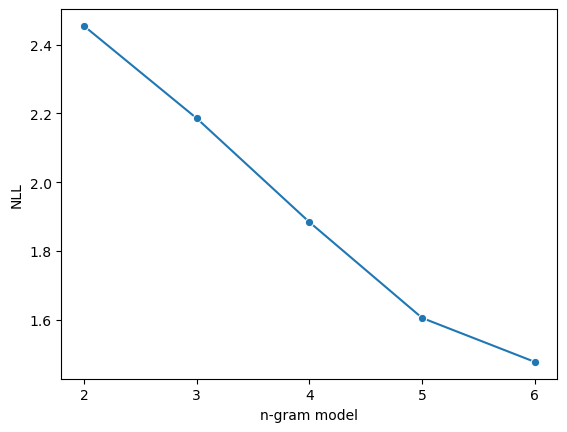

In [7]:
import seaborn as sns

ax = sns.lineplot(x=list(range(2, 7)), y=losses, marker="o")
ax.set(xlabel="n-gram model", ylabel="NLL")
ax.set_xticks(list(range(2,7)))

We see that the larger models perform better as they have more prior information when picking the next letter. Beyond 6-gram models, the space requirements grow too large, so we're going to limit them till there.

<font size='4'>
Lets now do the same, but use a neural network architecture. Firstly we need to construct the dataset and labels.
</font>

In [65]:
from itertools import product

class Dataset:
	def __init__(self, data):
		self.characterSet = set(''.join(data))
		self.characterSet.add('.')
		self.ctoi = {c: i for i, c in enumerate(sorted(list(self.characterSet)))}
		self.itoc = {i: c for c, i in self.ctoi.items()}

	def get_data(self, n):
		self.encoded = {c: i for i, c in enumerate(product(sorted(list(set(self.characterSet))), repeat=n))}
		self.decoded = lambda x: self.encoded[x]
		x, y = [], []
		for word in words:
			context = ["."]*n
			for char in word + ".":
				x.append(self.decoded(tuple(context)))
				y.append(self.ctoi[char])
				context = context[1:] + [char]
		self.train_data = (x, y)

In [12]:
dataset = Dataset(words)

We now need create a generalized one layer neural net without an activation function.

In [26]:
import torch.nn.functional as F
from math import exp

In [81]:
from typing import List, Union

class ngramNN:
	"""
	Generic neural net based class for next character prediction using a single layer of 27 neurons
	and no activation function.
	"""

	def __init__(self, n, dataset: Dataset):
		"""
		Initialize the generic neural net
		Arguments:
			n: integer that is the size of the context
		"""
		self.n = n
		self.w = None
		self.dataset = dataset

	def train(self, iterations: int, start_lr: float, end_lr: float, reg_strength: Union[bool, float] = 0.01, generator=None):
		"""
		Method to train the neural net given the data and labels, how many iterations to train for, learning rate
		regularization strength.
		Arguments:
			x_train: torch.Tensor containing all training data points for each update
			y_train: torch.Tensor containing all training labels for corresponding data points
			iterations: integer for number of update steps
			lr: float to determine update step size
			reg_strength: float to determine effect of regularization
		"""
		if isinstance(reg_strength, bool):
			if reg_strength:
				self.reg_strength = 0.01
			else:
				self.reg_strength = 0.0
		else:
			self.reg_strength = reg_strength

		if isinstance(generator, bool) and generator:
			generator = torch.Generator().manual_seed(2147483647)
		elif not isinstance(generator, torch.Generator):
			generator = None

		x, y = self.dataset.train_data
		x_train, y_train = torch.tensor(x, dtype=torch.int64), torch.tensor(y, dtype=torch.int64)

		if not self.w:
			self.w = torch.randn((len(self.dataset.encoded), 27), generator=generator, dtype=torch.float32, requires_grad=True)

		lr = start_lr
		lr_Step = (end_lr - start_lr) / iterations

		for i in range(iterations):
			# forward step
			logits = self.w[x_train]
			count = logits.exp()
			probs = count / count.sum(dim=1, keepdim=True)
			loss = -probs[torch.arange(y_train.nelement()), y_train].log().mean() + reg_strength * (self.w.data**2).mean()

			# backward step
			self.w.grad = None
			loss.backward()

			# update step
			self.w.data += -lr*self.w.grad
			lr += lr_Step

			#print(f"{loss=}")
			
	def eval(self, x = None, y = None):
		"""
		Method to evaluate the model on given data
		Arguments:
			x_test: torch.Tensor containing all test data
			y_test: torch.Tensor containing all corresponding labels
		Returns:
			mean negative log-likelihood of model over test data
		"""
		if not x:
			x, y = self.dataset.train_data
		
		x_test, y_test = torch.tensor(x, dtype=torch.int64), torch.tensor(y, dtype=torch.int64)
		logits = self.w[x_test]
		count = logits.exp()
		probs = count / count.sum(dim=1, keepdim=True)
		nll = -probs[torch.arange(y_test.nelement()), y_test].log().mean()  + self.reg_strength * (self.w.data**2).mean()

		print(f"Loss of {self.n+1}-gram neural net model: {nll.item()}")
		return nll.item()

	def __call__(self, x: Union[str, List[str], List[int]]):
		if isinstance(x, str):
			x = str.split()

		if isinstance(x, List[str]):
			x = torch.tensor(self.dataset.decoded(tuple(x)), dtype=torch.int64)
		elif isinstance(x, List[int]):
			x = torch.tensor(x, dtype=torch.int64)

		if isinstance(generator, bool) and generator:
			generator = torch.Generator().manual_seed(2147483647)
		elif not isinstance(generator, torch.Generator):
			generator = None

		#xenc = F.one_hot(x, len(self.dataset.encoded)).float()
		logits = self.w[x]
		count = logits.exp()
		probs = count/count.sum(dim=1, keepdim=True)
		choice = torch.multinomial(probs, 1, replacement=True, generator=generator).item()
		return choice
		
	def generate(self, n, generator=None):
		""" Generate n new things from the trained model. Can make it deterministic, by setting generator to True
		Otherwise can leave generator as None or provide own generator. """

		if isinstance(generator, bool) and generator:
			generator = torch.Generator().manual_seed(2147483647)
		elif not isinstance(generator, torch.Generator):
			generator = None

		for _ in range(n):
			context = [0]*self.n
			word = ''
			while True:
				x = torch.tensor(context, dtype=torch.int64)
				#xenc = F.one_hot(x, len(self.dataset.encoded)).float()
				logits = self.w[x]
				count = logits.exp()
				probs = count/count.sum(dim=1, keepdim=True)
				choice = torch.multinomial(probs, 1, replacement=True, generator=generator).item()
				if choice == 0:
					break
				word += self.dataset.itoc[choice]
				context = context[1:] + [choice]
			print(word)

Similar to the above experiments we will construct and train n-gram models for $n \in [2,6]$

In [34]:
losses = []
dataset = Dataset(words)

for i in range(1, 6):
	dataset.get_data(i)
	model = ngramNN(i, dataset)
	model.train(iterations=1000, start_lr=10, end_lr=0.1, reg_strength=0.01, generator=True)
	losses.append(model.eval())

Loss of 2-gram neural net model: 2.4894607067108154
Loss of 3-gram neural net model: 2.516617774963379
Loss of 4-gram neural net model: 2.901271343231201
Loss of 5-gram neural net model: 3.1651172637939453
Loss of 6-gram neural net model: 3.236952066421509


We can plot the final loss of each model and see how a more complex model performs

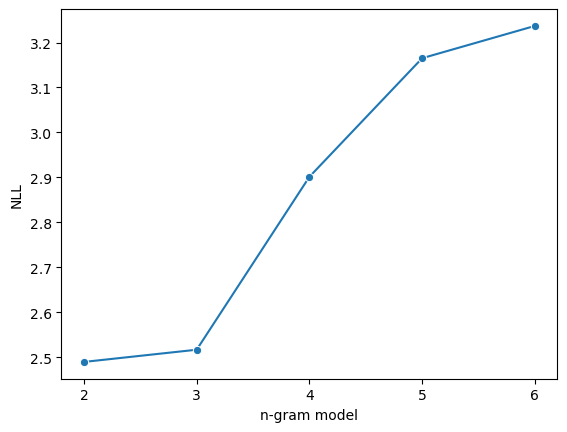

In [38]:
ax = sns.lineplot(x=list(range(2, 7)), y=losses, marker="o")
ax.set(xlabel="n-gram model", ylabel="NLL")
ax.set_xticks(list(range(2,7)))

So we can see that it is harder to train the Neural Net model, even after implementing a basic linear learning rate schedule. The more complex models also take much longer to learn. This is why going forward for the time we will only be working at most with a trigram model.

Also, we will modify our dataset class to split it into a train, dev, and test sets. We can then use the train set to train, the dev set to tune the strength of our regularization parameter and finally use the test set to evaluate our final model.

In [77]:
from itertools import product
import random

class Dataset:
    def __init__(self, data):
        self.characterSet = set(''.join(data))
        self.characterSet.add('.')
        self.ctoi = {c: i for i, c in enumerate(sorted(list(self.characterSet)))}
        self.itoc = {i: c for c, i in self.ctoi.items()}

    def set_data(self, n):
        self.encoded = {c: i for i, c in enumerate(product(sorted(list(set(self.characterSet))), repeat=n))}
        self.decoded = lambda x: self.encoded[x]
        self.x, self.y = [], []
        for word in words:
            context = ["."]*n
            for char in word + ".":
                self.x.append(self.decoded(tuple(context)))
                self.y.append(self.ctoi[char])
                context = context[1:] + [char]    

    def split_data(self, train_size, dev_size, test_size):
        # make sure the dataset sizes add up to 1
        assert train_size + dev_size + test_size == 1, "train_size + dev_size + test_size must be 1"
        # generate list of shuffled indices 
        shuffled_indices = list(range(len(self.x)))
        random.shuffle(shuffled_indices)

        train_size = int(train_size * len(self.x))
        dev_size = int(dev_size * len(self.x))
        
        # split the data using the shuffled indices
        self.train_data = ([self.x[i] for i in shuffled_indices[:train_size]], [self.y[i] for i in shuffled_indices[:train_size]])
        self.dev_data = ([self.x[i] for i in shuffled_indices[train_size:train_size+dev_size]], [self.y[i] for i in shuffled_indices[train_size:train_size+dev_size]])
        self.test_data = ([self.x[i] for i in shuffled_indices[train_size+dev_size:]], [self.y[i] for i in shuffled_indices[train_size+dev_size:]])

Firstly we will split the dataset in the ratio 0.8:0.1:0.1, but not tune the regularization strength. This will give us an insight to how the model performs without any tuning.

In [83]:
dev_set_losses = []
test_set_losses = []
dataset = Dataset(words)

for i in range(1, 3):
	dataset.set_data(i)
	dataset.split_data(0.8, 0.1, 0.1)
	model = ngramNN(i, dataset)
	model.train(iterations=1000, start_lr=10, end_lr=0.1, reg_strength=0.01, generator=True)
	dev_set_losses.append(model.eval(*dataset.dev_data))
	test_set_losses.append(model.eval(*dataset.test_data))

Loss of 2-gram neural net model: 2.479473829269409
Loss of 2-gram neural net model: 2.495181083679199
Loss of 3-gram neural net model: 2.528745174407959
Loss of 3-gram neural net model: 2.5251917839050293


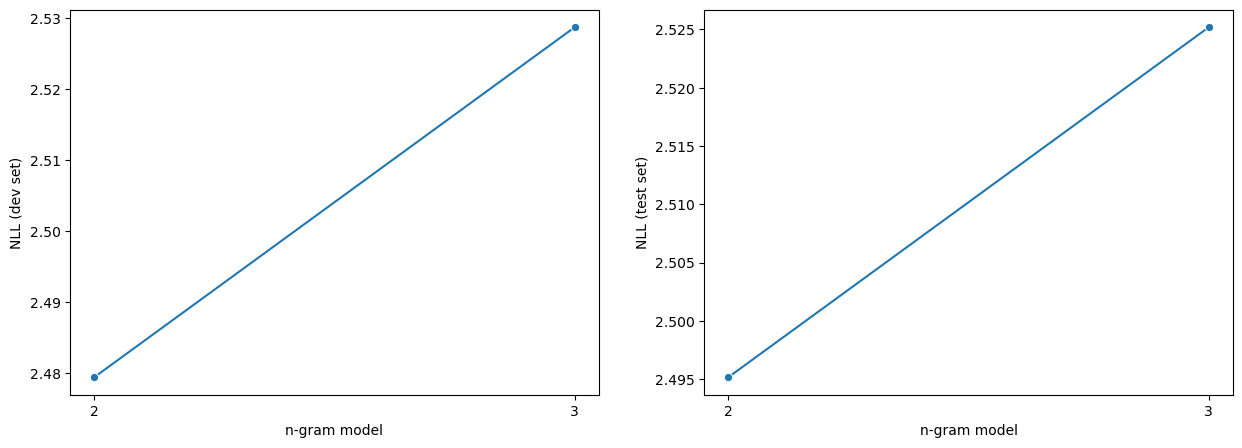

In [87]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.lineplot(x=list(range(2, 4)), y=dev_set_losses, marker="o", ax=ax[0])
ax[0].set(xlabel="n-gram model", ylabel="NLL (dev set)")
ax[0].set_xticks(list(range(2,4)))
sns.lineplot(x=list(range(2, 4)), y=test_set_losses, marker="o", ax=ax[1])
ax[1].set(xlabel="n-gram model", ylabel="NLL (test set)")
ax[1].set_xticks(list(range(2,4)))

So we see that both the brigram and trigram models perform approximately equally on both the dev and test set. This is because in this scenario they are both acting as evaluation sets. Now we can use the dev set to tune the regulatization parameter and evaluate the final model on the test set. We will use a list of regularization strength parameter settings and see which one performs the best. Let us use values ranging from 1 to $10^{-4}$. We will also keep the learning rate constant in these experiments instead of emplying the linear learning rate schedule.

Loss of 2-gram neural net model: 2.482201099395752
Loss of 2-gram neural net model: 2.484097957611084
Loss of 2-gram neural net model: 2.5030674934387207
Loss of 2-gram neural net model: 2.6927595138549805
Loss of 2-gram neural net model: 4.5896806716918945
Loss of 3-gram neural net model: 2.4028775691986084
Loss of 3-gram neural net model: 2.4038095474243164
Loss of 3-gram neural net model: 2.413126230239868
Loss of 3-gram neural net model: 2.5062944889068604
Loss of 3-gram neural net model: 3.4379749298095703


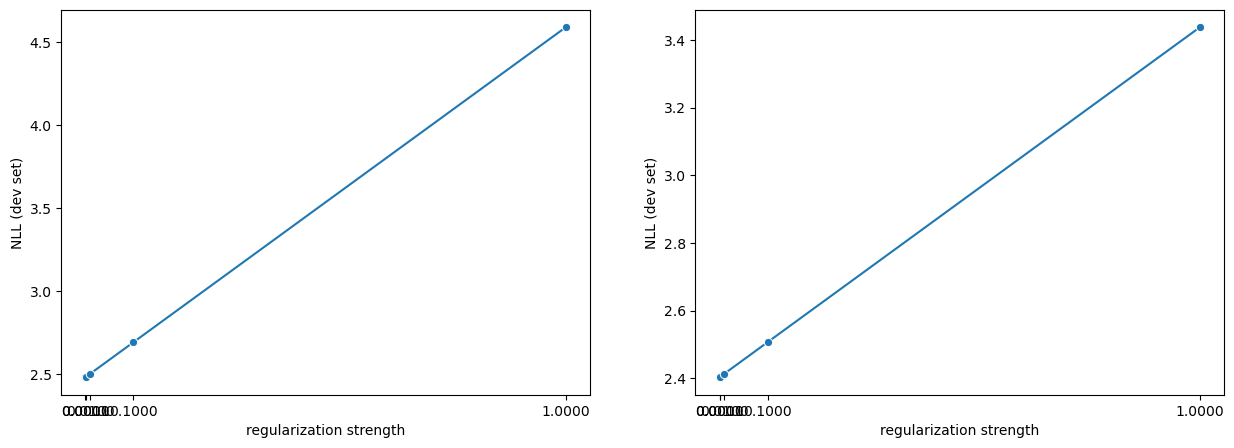

In [89]:
regularization_strengths = [10**i for i in range(-4, 1, 1)]
dataset = Dataset(words)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

for i in range(1, 3):
    dataset.set_data(i)
    dataset.split_data(0.8, 0.1, 0.1)
    dev_set_losses = []
    for reg_strength in regularization_strengths:
        model = ngramNN(i, dataset)
        model.train(iterations=1000, start_lr=10, end_lr=10, reg_strength=reg_strength, generator=True)
        dev_set_losses.append(model.eval(*dataset.dev_data))

    sns.lineplot(x=regularization_strengths, y=dev_set_losses, marker="o", ax=ax[i-1])
    ax[i-1].set(xlabel="regularization strength", ylabel="NLL (dev set)")
    ax[i-1].set_xticks(regularization_strengths)

As we can see from the graphs above, as we increase the regularization strength from $10^{-4}$ to 1, each model does worse. So we want to select the lowest regularization strength and use the models trained with them to evaluate our model using the test data set.

In [90]:
for i in range(1, 3):
    dataset.set_data(i)
    dataset.split_data(0.8, 0.1, 0.1)
    dev_set_losses = []
    model = ngramNN(i, dataset)
    model.train(iterations=1000, start_lr=10, end_lr=10, reg_strength=10**-4, generator=True)
    model.eval(*dataset.test_data)

Loss of 2-gram neural net model: 2.4687671661376953
Loss of 3-gram neural net model: 2.386749505996704


As we can see, both models perform well on the test dataset, especially the trigram model in comparison to the earlier experiments where we trained multiple n-gram models without varying the regularization strength.

It is also worth noting in the Neural Net class definition, we don't use one-hot encoded vectors. Instead we just use the indices of the training data to access the row of the weight matrix.

Now we want to explore the usage of the cross-entropy loss function provided instead of our calculation, and see if we can observe any differences.

In [92]:
from typing import List, Union

class ngramNN:
	"""
	Generic neural net based class for next character prediction using a single layer of 27 neurons
	and no activation function.
	"""

	def __init__(self, n, dataset: Dataset):
		"""
		Initialize the generic neural net
		Arguments:
			n: integer that is the size of the context
		"""
		self.n = n
		self.w = None
		self.dataset = dataset

	def train(self, iterations: int, start_lr: float, end_lr: float, reg_strength: Union[bool, float] = 0.01, generator=None):
		"""
		Method to train the neural net given the data and labels, how many iterations to train for, learning rate
		regularization strength.
		Arguments:
			x_train: torch.Tensor containing all training data points for each update
			y_train: torch.Tensor containing all training labels for corresponding data points
			iterations: integer for number of update steps
			lr: float to determine update step size
			reg_strength: float to determine effect of regularization
		"""
		if isinstance(reg_strength, bool):
			if reg_strength:
				self.reg_strength = 0.01
			else:
				self.reg_strength = 0.0
		else:
			self.reg_strength = reg_strength

		if isinstance(generator, bool) and generator:
			generator = torch.Generator().manual_seed(2147483647)
		elif not isinstance(generator, torch.Generator):
			generator = None

		x, y = self.dataset.train_data
		x_train, y_train = torch.tensor(x, dtype=torch.int64), torch.tensor(y, dtype=torch.int64)

		if not self.w:
			self.w = torch.randn((len(self.dataset.encoded), 27), generator=generator, dtype=torch.float32, requires_grad=True)

		lr = start_lr
		lr_Step = (end_lr - start_lr) / iterations

		for i in range(iterations):
			# forward step
			logits = self.w[x_train]
			# count = logits.exp()
			# probs = count / count.sum(dim=1, keepdim=True)
			loss = F.cross_entropy(logits, y_train) + reg_strength * (self.w.data**2).mean()

			# backward step
			self.w.grad = None
			loss.backward()

			# update step
			self.w.data += -lr*self.w.grad
			lr += lr_Step

			#print(f"{loss=}")
			
	def eval(self, x = None, y = None):
		"""
		Method to evaluate the model on given data
		Arguments:
			x_test: torch.Tensor containing all test data
			y_test: torch.Tensor containing all corresponding labels
		Returns:
			mean negative log-likelihood of model over test data
		"""
		if not x:
			x, y = self.dataset.test_data
		
		x_test, y_test = torch.tensor(x, dtype=torch.int64), torch.tensor(y, dtype=torch.int64)
		logits = self.w[x_test]
		# count = logits.exp()
		# probs = count / count.sum(dim=1, keepdim=True)
		nll = F.cross_entropy(logits, y_test)  + self.reg_strength * (self.w.data**2).mean()

		print(f"Loss of {self.n+1}-gram neural net model: {nll.item()}")
		return nll.item()

	def __call__(self, x: Union[str, List[str], List[int]]):
		if isinstance(x, str):
			x = str.split()

		if isinstance(x, List[str]):
			x = torch.tensor(self.dataset.decoded(tuple(x)), dtype=torch.int64)
		elif isinstance(x, List[int]):
			x = torch.tensor(x, dtype=torch.int64)

		if isinstance(generator, bool) and generator:
			generator = torch.Generator().manual_seed(2147483647)
		elif not isinstance(generator, torch.Generator):
			generator = None

		#xenc = F.one_hot(x, len(self.dataset.encoded)).float()
		logits = self.w[x]
		count = logits.exp()
		probs = count/count.sum(dim=1, keepdim=True)
		choice = torch.multinomial(probs, 1, replacement=True, generator=generator).item()
		return choice
		
	def generate(self, n, generator=None):
		""" Generate n new things from the trained model. Can make it deterministic, by setting generator to True
		Otherwise can leave generator as None or provide own generator. """

		if isinstance(generator, bool) and generator:
			generator = torch.Generator().manual_seed(2147483647)
		elif not isinstance(generator, torch.Generator):
			generator = None

		for _ in range(n):
			context = [0]*self.n
			word = ''
			while True:
				x = torch.tensor(context, dtype=torch.int64)
				#xenc = F.one_hot(x, len(self.dataset.encoded)).float()
				logits = self.w[x]
				count = logits.exp()
				probs = count/count.sum(dim=1, keepdim=True)
				choice = torch.multinomial(probs, 1, replacement=True, generator=generator).item()
				if choice == 0:
					break
				word += self.dataset.itoc[choice]
				context = context[1:] + [choice]
			print(word)

In [94]:
dataset = Dataset(words)
dataset.set_data(1)
dataset.split_data(0.8, 0.1, 0.1)
model = ngramNN(1, dataset)
model.train(1000, 10, 10, 0.01)
model.eval()

Loss of 2-gram neural net model: 2.4859840869903564


2.4859840869903564

We can see that we're getting a similar result as when we calculated the loss ourselves. The adavantage of using this loss instead of our own is we do not have to get the counts matrix and normalize it to calculate the loss. This saves us computation and speeds up the training and evaluation process as the underlying code is optimized instead of the computationally intensive code we use to create new tensors for each operation.